In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the dataset
#datastore = pd.read_csv("Utterances_Training_Dataset(Modified).csv")
datastore = pd.read_csv("Utterances_Intents.csv")

datastore.info()
datastore.head()

class_names: ["Contact Human Agent", "Medicine Suggestion Query", "Medicine Availability Query", "Price Check"]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188 entries, 0 to 1187
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   utterance  1188 non-null   object
 1   intent     1188 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.7+ KB


In [5]:
#Remove the stopwords in utterances
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import contractions

stop_words = set(stopwords.words('english'))

def removeStopWords(sentence):
    filtered_result = ""
    sent_tokenized = contractions.fix(sentence)
    sent_tokenized = word_tokenize(sent_tokenized)
    print(f"sent_tokenized: {sent_tokenized}")
    for word in sent_tokenized:
        print(f"Checking if {word} is a stop_word")
        if word.casefold() not in stop_words:
            filtered_result = filtered_result + " "+ word
    filtered_result = filtered_result.strip()
    #print(filtered_result)
    return filtered_result

#removeStopWords(utterance[0])
datastore['utterance'] = datastore['utterance'].apply(removeStopWords)


datastore

sent_tokenized: ['could', 'I', 'talk', 'to', 'a', 'human', '?']
Checking if could is a stop_word
Checking if I is a stop_word
Checking if talk is a stop_word
Checking if to is a stop_word
Checking if a is a stop_word
Checking if human is a stop_word
Checking if ? is a stop_word
sent_tokenized: ['you', 'are', 'not', 'helping', ',', 'how', 'do', 'I', 'contact', 'a', 'human', '?']
Checking if you is a stop_word
Checking if are is a stop_word
Checking if not is a stop_word
Checking if helping is a stop_word
Checking if , is a stop_word
Checking if how is a stop_word
Checking if do is a stop_word
Checking if I is a stop_word
Checking if contact is a stop_word
Checking if a is a stop_word
Checking if human is a stop_word
Checking if ? is a stop_word
sent_tokenized: ['I', 'ac', "n't", 'understand', 'you', ',', 'what', 'can', 'I', 'do', 'to', 'talk', 'to', 'a', 'human', '?']
Checking if I is a stop_word
Checking if ac is a stop_word
Checking if n't is a stop_word
Checking if understand is a st

,utterance,intent
0,could talk human ?,0
1,"helping , contact human ?",0
2,"ac n't understand , talk human ?",0
3,"helping , speak human agent ?",0
4,contact human ?,0
...,...,...
1183,much biogesic available ?,3
1184,biogesic available purchase today available an...,3
1185,biogesic inventory today ?,3
1186,medicines available today ?,3


#Put all columns of dataframe into a list

#flags = datastore['flags'].values.tolist() -removed
utterance = datastore['utterance'].values.tolist()
#category = datastore['category'].values.tolist() -removed
intent = datastore['intent'].values.tolist()
training_labels = np.array(intent)

#print(utterance[0:4])

In [4]:
#Apply Naive Random Sampling
from sklearn.model_selection import cross_validate
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

#oversampler = RandomOverSampler(sampling_strategy={1:150, 2:150, 3:150},random_state=888)
undersampler = RandomUnderSampler(sampling_strategy={0:30}, random_state=888)
new_data, new_shape = undersampler.fit_resample(datastore, datastore['intent']) #Create new samples

print(f"new_data:\n{new_data}")

#Create dictionary out of the new samples
newSamples = {
    "utterance" : [utterance for utterance in new_data],
    "intents" : [intent for intent in new_shape]
}

# Create the pandas DataFrame 
resampleDF = pd.DataFrame(new_data, columns=['utterance', 'intent']) 
  
# print dataframe.
#print(resampleDF)
#print('Resampled dataset shape {}'.format(Counter(new_shape)))

ModuleNotFoundError: No module named 'sklearn'

print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

In [7]:
from sklearn.model_selection import train_test_split

#Splitting the dataset into training and testing sets
train_df, test_df = train_test_split(resampleDF, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#Assign utterances to variables
train_utterances = train_df['utterance']
testing_utterances = test_df['utterance']
validation_utterances = val_df['utterance']

#Put intents (target labels) of each record into array
training_labels = np.array(train_df['intent'])
testing_labels = np.array(test_df['intent'])
validation_labels = np.array(val_df['intent'])
print(training_labels)

[0 2 1 0 2 2 1 1 2 1 3 0 1 1 0 1 1 2 2 0 2 2 0 1 1 2 2 1 1 1 2 2 1 1 0 1 1
 1 1 2 1 1 0 3 0 0 2 3 1 3 1 2 1 3 3 1 0 2 0 1 2 1 0 1 3 1 1 2 1 3 1 0 0 1
 0 1 2 1 1 2 1 3 2 1 1 3 1 0 1 0 0 1 2 3 1 1 1 1 1 3 3 1 1 1 1 1 3 3 1 1 2
 1 1 1 3 3 1 1 1 2 1 1]


In [8]:
#Parameters of Tokenizer
vocab_size = 1000
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(train_df['utterance'])

# Print the length of the word index
word_index = tokenizer.word_index
print(f'number of words in word_index: {len(word_index)}')

# Print the word index
print(f'word_index: {word_index}')
print()

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(train_df['utterance'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Print a sample
index = 2
print(f'sample string: {training_sequences[index]}')
print(f'padded sequence: {training_padded[index]}')

# Print dimensions of padded sequences
print(f'shape of padded sequences: {training_padded.shape}')

#Testing and Validations sets
testing_sequences = tokenizer.texts_to_sequences(test_df['utterance'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(val_df['utterance'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Testing Padded: {testing_padded[0:2]}")

#print(f"Test: {tokenizer.texts_to_sequences(['I wanna talk to a human'])}")

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

#Normalize data
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [11]:
#Parameters of the model
embedding_dim = 64
lstm_dim = 16
dense_dim = 128
num_of_classes = 5

import tensorflow as tf
import keras

# Vocabulary size and number of words in a sequence.
vocab_size = 10000
sequence_length = 50

# Use the text vectorization layer to normalize, split, and map strings to
# integers.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)


vectorize_layer.adapt(train_utterances)

In [45]:
import tensorflow as tf
import tensorflow.keras.layers
import keras.losses

#Define the Model
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_of_classes)
])

# Set the training parameters
model_lstm.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),optimizer='adam',metrics=[keras.metrics.sparse_categorical_accuracy])

# Print the model summary
model_lstm.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 64)            64000     
                                                                 
 dropout_36 (Dropout)        (None, 50, 64)            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               4224      
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                     

In [46]:
#Callbacks for the model
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["sparse_categorical_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

my_callback = MyThresholdCallback(threshold=0.95)

NUM_EPOCHS = 40

# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, validation_data=(validation_padded, validation_labels), callbacks=[my_callback])



# Print the model summary
model_lstm.summary()

Epoch 1/40
4/4 [==============================] - 3s 245ms/step - loss: 1.6051 - sparse_categorical_accuracy: 0.3197 - val_loss: 1.5817 - val_sparse_categorical_accuracy: 0.5484
Epoch 2/40
4/4 [==============================] - 0s 31ms/step - loss: 1.5763 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.5455 - val_sparse_categorical_accuracy: 0.5484
Epoch 3/40
4/4 [==============================] - 0s 32ms/step - loss: 1.5353 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.4991 - val_sparse_categorical_accuracy: 0.5484
Epoch 4/40
4/4 [==============================] - 0s 32ms/step - loss: 1.4889 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.4358 - val_sparse_categorical_accuracy: 0.5484
Epoch 5/40
4/4 [==============================] - 0s 32ms/step - loss: 1.4359 - sparse_categorical_accuracy: 0.5082 - val_loss: 1.3559 - val_sparse_categorical_accuracy: 0.5484
Epoch 6/40
4/4 [==============================] - 0s 32ms/step - loss: 1.3695 - sparse_categorical_accuracy: 0.508

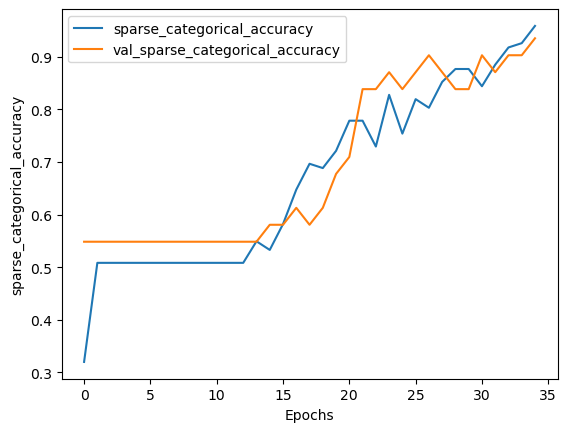

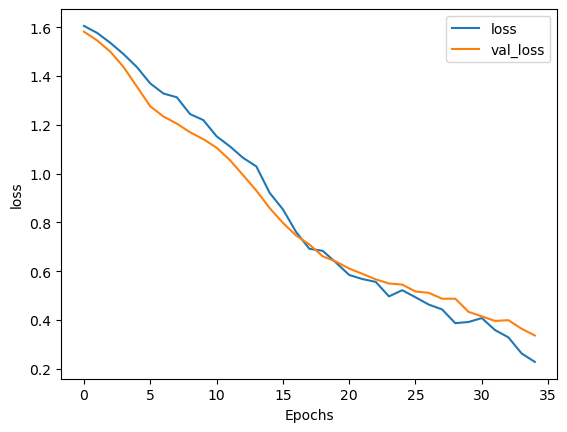

In [47]:
# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, "sparse_categorical_accuracy")
plot_graphs(history_lstm, 'loss')

In [122]:
val_df

,utterance,intent
1119,urinary tract infection need something relief ...,1
1067,"prone motion sickness , especially car rides ....",1
1112,prone seasickness boat trips . OTC remedy take...,1
1052,going camping trip want prepared minor injurie...,1
1096,"need something allergy relief , specifically i...",1
1109,"need something allergy relief , particularly n...",1
1146,experience side effects ?,2
1066,"joints stiff , especially morning . suggest OT...",1
1045,occasional nausea . suggest over-the-counter r...,1
1093,trouble focusing day . supplement medication i...,1


In [57]:
from keras.models import Model, Sequential #This works apparently and I have no idea why

probability_model = Sequential([model_lstm, tf.keras.layers.Softmax()])

def getIntent(user_prompt):
    print(f"User Prompt: {user_prompt}")
    tokens = tokenizer.texts_to_sequences([user_prompt])
    print(f"Tokens: {tokens}")
    tokens = pad_sequences(tokens, maxlen=max_length, padding=padding_type)
    probabilities = probability_model.predict(tokens)
    print(f"Probabilities: {probabilities}")
    predicted_label = np.argmax(probabilities)
    #print(f"Tokens: {tokens}")
    return predicted_label

In [74]:
#prompt = "How to take Biogesic"
validation_test_index = 12
#Notable indexes: 24, 26

#print(f"Intent is: {getIntent(val_df['utterance'].iloc[[validation_test_index]].values[0])}")
#print(f"Original Intent from Validation Set is {val_df['intent'].iloc[[validation_test_index]].values[0]}")

print(f"Intent is: {getIntent('Let me talk to someone.')}")

User Prompt: Let me talk to someone.
Tokens: [[1, 1, 23, 1, 61]]
1/1 [==============================] - 0s 21ms/step
Probabilities: [[0.5209998  0.01009428 0.3523096  0.11414703 0.00244931]]
Intent is: 0


In [50]:
history_dict = history_lstm.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

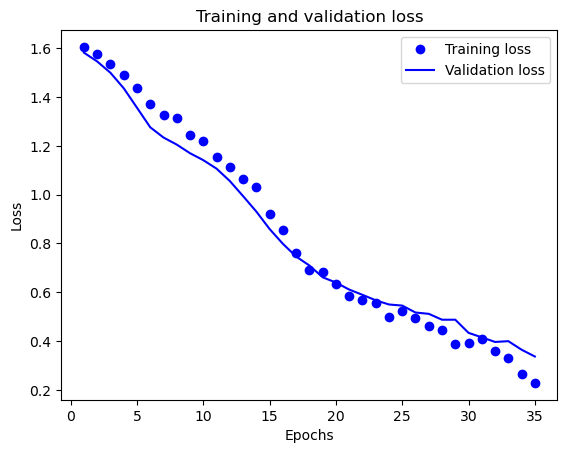

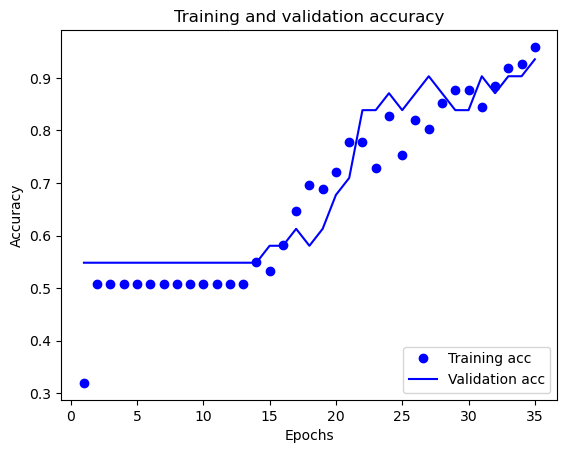

In [51]:
acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [52]:
#Save and load tokenizer
import io, json
from keras_preprocessing.text import tokenizer_from_json

tokenizer_json = tokenizer.to_json()
with io.open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
    
with open('tokenizer.json') as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [53]:
#Save the model
model_lstm.save('intent_recognition_model.keras')

In [54]:
#Load model
new_model = keras.models.load_model('intent_recognition_model.keras')

#Check summary of the model
new_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 50, 64)            64000     
                                                                 
 dropout_36 (Dropout)        (None, 50, 64)            0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 32)               10368     
 onal)                                                           
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_26 (Dense)            (None, 128)               4224      
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                     

In [55]:
loss, acc = new_model.evaluate(testing_padded, testing_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(testing_padded).shape)

2/2 - 1s - loss: 0.2259 - sparse_categorical_accuracy: 0.8974 - 560ms/epoch - 280ms/step
Restored model, accuracy: 89.74%
2/2 [==============================] - 1s 4ms/step
(39, 5)


In [18]:
text_dataset = tf.data.Dataset.from_tensor_slices([
                                                   "this is some clean text", 
                                                   "some more text", 
                                                   "even some more text"]) 
# Fit a TextVectorization layer
vectorizer = TextVectorization(max_tokens=10, output_mode='tf-idf',ngrams=None)    
vectorizer.adapt(text_dataset.batch(1024))

# Vector for word "this"
print (vectorizer("this"))

# Pickle the config and weights
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("textvect_layer.pkl", "wb"))

print ("*"*10)
# Later you can unpickle and use 
# `config` to create object and 
# `weights` to load the trained weights. 

from_disk = pickle.load(open("textvect_layer.pkl", "rb"))
new_v = TextVectorization.from_config(from_disk['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
#new_v.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
new_v.set_weights(from_disk['weights'])

# Lets see the Vector for word "this"
print (new_v("this"))

NameError: name 'tokenizer_from_json' is not defined

In [ ]:
#New test model

#Define the Model
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='sigmoid'),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(num_of_classes, activation='softmax')
])

# Set the training parameters
model_lstm.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics='sparse_categorical_accuracy')

# Print the model summary
#model_lstm.summary()